# Assignment 1

submitted by :
Tair Hakman & Yaniv Bin 

## Part 1 

### part 1.1

First We'd like to start with importing all the modules we're going to use in this notebook:

In [1]:
import nltk
import os
import re, pprint, collections
from urllib import request
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
import numpy as np
from os.path import abspath, dirname, join
import inspect
import matplotlib.pyplot as plt
import matplotlib
import math
from math import log
import random
from collections import *
import zipfile, tarfile
import string

and preparing the ptb set given in the file:

In [ ]:
!wget http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz

tar = tarfile.open("simple-examples.tgz","r") 
for item in tar:
    tar.extract(item, "ptb")

We use the following code in order to tokenize the data based on the ptb method:

In [4]:
def replace_numbers(tokens):
    return [x if not x.isdigit() else 'N' for x in tokens]

def find_most_common(tokens, top):
    counter = collections.Counter(tokens)
    most_common = counter.most_common(top)
    return [a for a, b in most_common]

def replace_noncommon_tokens(sentences, most_common):
    res = []
    for sentence in sentences:
        res.append([x if (x in most_common) else '<unk>' for x in sentence])
    return res

def ptb_preprocess(filenames, top=10000):
    for single_file in filenames:
        path = nltk.data.find(single_file)
        raw = open(path, 'r').read()
        segments = raw.split("\n")
        sentences = []
        for segment in segments:
            tokens = word_tokenize(segment)
            # remove punctuation
            tokens = [x for x in tokens if x not in string.punctuation]
            # to lowercase
            words = [w.lower() for w in tokens]
            # filter numbers
            sentence = replace_numbers(words)
            
            sentences.append(sentence)
       
        # get most common words and replace all other words with unk
        common_tokens = find_most_common([word for sentence in sentences for word in sentence], top)
        sentences = replace_noncommon_tokens(sentences, common_tokens)
        
        # write out the new data into a file 
        new_filename = single_file + ".out"
        with open(new_filename, 'w') as f:
            for sentence in sentences:
                for word in sentence:
                    f.write("%s " % word)
                f.write("\n")

We want to test the above code on a few example files:

In [ ]:
path_to_first_file = abspath(join(dirname("__file__"), "segmentationExample.txt"))
path_to_second_file = abspath(join(dirname("__file__"), "SplitAndPuncExample.txt"))
path_to_third_file = abspath(join(dirname("__file__"), "numbersExample.txt"))
path_to_file_four = abspath(join(dirname("__file__"), "uncommonExample.txt"))

ptb_preprocess([path_to_first_file, path_to_second_file, path_to_third_file], 10000)

For example the file "segmentationExample.text" which contains the following lines:

In [ ]:
with open(path_to_first_file) as f:
    print(f.read())

Will result in the file "segmentationExample.text.out":

In [ ]:
path_to_first_result = abspath(join(dirname("__file__"), "segmentationExample.txt.out"))
with open(path_to_first_result) as f:
    print(f.read())

The file "SplitAndPuncExample.txt" :

In [ ]:
with open(path_to_second_file) as f:
    print(f.read())

Will result in the files "SplitAndPuncExample.txt.out"

In [ ]:
path_to_second_result = abspath(join(dirname("__file__"), "SplitAndPuncExample.txt.out"))
with open(path_to_second_result) as f:
    print(f.read())

The file "numbersExample.txt":

In [ ]:
with open(path_to_third_file) as f:
    print(f.read())

Will result in the files "numbersExample.txt.out":

In [ ]:
path_to_third_result = abspath(join(dirname("__file__"), "numbersExample.txt.out"))
with open(path_to_third_result) as f:
    print(f.read())

to show uncommon words filtering we will reduce the size of filtering (indtead of a 10000) to 10:

In [ ]:
ptb_preprocess([path_to_file_four], 10)

if we test it with the file "uncommonExample.txt":

In [ ]:
with open(path_to_file_four) as f:
    print(f.read())

we get:

In [ ]:
path_to_file_four_result = abspath(join(dirname("__file__"), "uncommonExample.txt.out"))
with open(path_to_file_four_result) as f:
    print(f.read())

the results for running our tokenizer on shakespears work:

In [ ]:
path_to_shakespear = abspath(join(dirname("__file__"), "shakespear.txt"))
ptb_preprocess([path_to_shakespear], 10000)

can be found under a file called "shakespear.txt.out" attached to the assignment

#### part 1.1.2 

We will gather the statistics on the dev file given in 

## part 1.2

the following is an implementation of the ngram model:

In [2]:
class NgramModel(object):
    def __init__(self, n, train, smoothing=False, estimator=None):
        self._n = n
        self.is_unigram_model = (n == 1)
        self.is_smooth = smoothing
        
        cfd = nltk.ConditionalFreqDist((" ".join(train[i : i + n - 1]), "".join(train[i + n - 1])) for i in range(len(train) - n + 1))
        self._probdist = nltk.ConditionalProbDist(cfd, estimator)
        
        # if we are not using smoothing we should implement a backoff model and keep all the seen ngrams
        if not self.is_smooth:
            self._ngramsData = ngrams(train, n)
            self._ngrams = set()
            for ngram in self._ngramsData:
                self._ngrams.add(ngram)
        
        if not self.is_unigram_model:
            if not self.is_smooth:
                self._backoff = NgramModel(n - 1, train, estimator=estimator)
                self._lambda = 1
    
    def prob(self, word, context):
        if (self.is_smooth and self._probdist[context].logprob(word) != 0):
            return self._probdist[context].logprob(word)
        
        # if we are not using smoothing we need to use a different method for avoiding 0 probability 
        elif (tuple(context.split()) + (word, ) in self._ngrams) or (self.is_unigram_model):
            return self._probdist[context].logprob(word)
        else:
            new_context = " ".join(context.split()[1:])
            backoff = self._backoff.prob(word, new_context)
            return self._lambda * backoff
        
    def logprob(self, word, context):
        return - self.prob(word, context)
    
    def get_seed(self):
        return random.choice(self._probdist.conditions())
    
    def generate(self, seed, length):
        out = []
        curr = seed
        end = self._probdist.conditions()[-1]
        i = 0
        while (i <= length and (not curr == end)):
          i += 1
          word = self._probdist[curr].generate()
          curr = " ".join((curr.split())[1:] + [word])
          out.append(word)
        return out

In [3]:
def train_word_lm(dataset, n=2):
    model = NgramModel(n, dataset, estimator=nltk.MLEProbDist)
    return model

The data structure required to build the model is - a dictionary of size at most the number of N-grams multiplied by the size of the vocabulary - so we get:

In [ ]:
%%latex
\begin{align}
{\mathbf{dictSize}} & = \frac{{\mathbf{Vocabulary}}}{N} * \mathbf{Vocabulary}
\end{align}

Aside from that we also save an array of all possible ngrams, and the backoff in case we don't use a smoothing technique.
To save the backoff - that is in order to use the backoff technique over the perplexity calculations - the data structure is similar and defined recursively.
One can also note we did not implement a smoothing as a Katz backoff using alpha - but a more accturate results would have been preduced if we did so. 

As we can see in the given class implementation - the model should export methods for evaluating itself, for generating random text, and for calculating the probabilty and entropy of a word given a context. 

the memory required for holding the model(non smoothing) is therefore at most: 

In [18]:
%%latex
\begin{align}
{\mathbf{dictSize_N}} & = \frac{{\mathbf{Vocabulary}}}{N} * \mathbf{Vocabulary} \\
{\mathbf{Memory}} & = {\mathbf{dictSize_N}} + {\mathbf{dictSize_(N + 1)}} + \dots + {\mathbf{dictSize_1}} + {\mathbf(size-of-ngrams)}
\end{align}

<IPython.core.display.Latex object>

for a smoothing using model - we don't need to save anything other than the initial ngram dictionary (no need to build it using recursion or keeping all seen ngrams), in that case it takes a much smaller memory of at most: 

In [14]:
%%latex
\begin{align}
{\mathbf{dictSize_N}} & = \frac{{\mathbf{Vocabulary}}}{N} * \mathbf{Vocabulary} \\
\end{align}

<IPython.core.display.Latex object>

## part 1.3

We'd like to measure how well our model is doing, we can do so by using a measure called perplexity - a model perplexity can be evaluated as followed:

In [4]:
def model_entropy(model, text, n=2):
    H = 0.0
    for i in range(n - 1, len(text)):
        context, word = tuple(text[i - n + 1:i]), text[i]
        context = " ".join(context)
        H += model.logprob(word, context)
    return H / float(len(text) - (n - 1))

def calc_preplexity(model, text, n=2):
    text_entropy = model_entropy(model, text, n)
    return 2 ** (text_entropy)

The lower the perplexity - the better the model.

When testing the above implemented model on the ptb training and validation data we get:

In [5]:
ptb_train_path = abspath(join(dirname("__file__"), "ptb/simple-examples/data/ptb.train.txt"))
ptb_test_path = abspath(join(dirname("__file__"), "ptb/simple-examples/data/ptb.test.txt"))
ptb_train_tokenized = (open(ptb_train_path, 'r').read()).split()
ptb_test_tokenized = (open(ptb_test_path, 'r').read()).split()

In [8]:
# Train the ngram model with n = 3
n = 3
lm_MLE = train_word_lm(ptb_train_tokenized, n)

print(calc_preplexity(lm_MLE, ptb_test_tokenized, n))

107.32412922857847


As mentioned, we can always use a different estimator in order to change our model perplexity, for example, the following model is using the Lidstone estimator with a gamma instead of the MLE one:

In [6]:
def train_word_lm_lidstone(dataset, n=2, gamma=0.01):
    lidstone_estimator = lambda fd: nltk.LidstoneProbDist(fd, gamma, fd.B() + 100)
    model = NgramModel(n, dataset,smoothing=True, estimator=lidstone_estimator)
    return model

In this case we don't need to use the backoff technique because the lidstone estimator provides a smoothing over the probabilities - instead of using regular MLE it's like creating "bins" and the depositing an initial amount into each bin, and then add to that all the actual probabilities. By doing so we will never reach a point where the probability is 0 (unless gamma is 0).
The formula it uses to do so is described as (for an experiment with count c, B bins and N outcomes) - 

In [ ]:
%%latex
\begin{align}
\frac{{\mathbf{c + gamma}}}{\mathbf{N + B * gamma}} \\
\end{align}

Notice how selecting the size of B can change the probability - We chose this value after some trial and error with the values, intending to not create a too sparse result. 

We get the following perplexity:

In [10]:
n = 3
gamma = 0.01
lm_LIDSTONE = train_word_lm_lidstone(ptb_train_tokenized, n, gamma)
print(calc_preplexity(lm_LIDSTONE, ptb_test_tokenized, n))

131.03836275826552


The following graph shows how differnt gamma values in such model change the results of the function:

In [13]:
gammas = np.linspace(0.01, 1, 20)
n = 3
perplexities_l = list(range(20))
i = 0
for gamma in gammas:
    lm_LIDSTONE = train_word_lm_lidstone(ptb_train_tokenized, n, gamma)
    perplexities_l[i] = calc_preplexity(lm_LIDSTONE, ptb_test_tokenized, n)
    i += 1

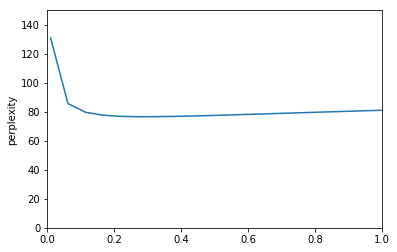

In [19]:
plt.plot(gammas, perplexities_l)
plt.axis([0, 1, 0, 150])
plt.ylabel("perplexity")
plt.show()

another way is to change the value of the n-grams , and that results in different perplexity - an example of the difference can be seen in the following graph:

In [11]:
perplexities_m = list(range(2, 20))
gamma = 0.01

for n in range(2, 20):
    lm_LIDSTONE = train_word_lm_lidstone(ptb_train_tokenized, n, gamma)    
    perp = calc_preplexity(lm_LIDSTONE, ptb_test_tokenized, n)
    perplexities_m[n - 2] = perp

222.34568792531184
131.03836275826552
92.68189306321692
86.8073309910055
88.1396212035187
90.23579833162498
91.866887156757
92.98319580473813
93.75392937489524
94.32844819478187
94.75903430473937
95.16790589088733
95.44106148718808
95.66883524570639
95.82513499124981
95.96614348993651
96.1112564570859
96.22072195944745


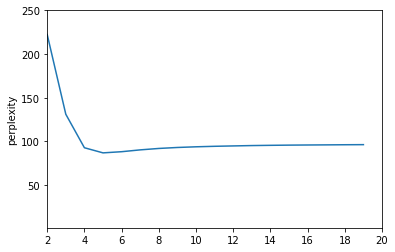

In [12]:
n_vals = list(range(2, 20))

plt.plot(n_vals, perplexities_m)
plt.axis([2, 20, 1, 250])
plt.ylabel("perplexity")
plt.show()

One can see starting with a low value of n we get really high perplexity(bad) and as we increase the value the perplexity gets better, that is until it reaches 7, that is because the ngrams are getting too large so most of them become unseen ngrams (a 7 words sentence is too long to be frequently repeated in the text) So the ideal size for n is at about n=6. 

based on the two models above and the two graphs, we can now compose the "ideal" model:

In [20]:
n = 6
gamma = 0.2
lm_IDEAL = train_word_lm_lidstone(ptb_train_tokenized, n, gamma)
print(calc_preplexity(lm_IDEAL, ptb_test_tokenized, n))

89.92074266919535


compared to the results from <TODO> 

### part 1.3.2 

Another way of using the model is by generating text using it, the following method generates text given a model and a seed(a starting prefix):

In [21]:
def generate(model, seed):
    out = model.generate(seed, 100)
    out = seed + " " + " ".join(out)

    print(out)

One can note this method is not ideal if the seed length is smaller than the ngram size we used to train the model, a way to avoid such problem is to find a matching ngram starting with the seed and running the method from there ) or just making sure the seed is big enough. Another way is the issue of halting - here I gave it a number of iteration or forced it to halt when it sees the last possible ngram. 
Another issue that might arise is if the model run into an unknown history, in my case the code will break, so one must make sure no unknown history will occure - to do so we have the condition in the while loop, another way to avoid it is similar to the backoff we can also reduce the ngram size down and go back a step with the probability (selecting next word based on that). 
I made this generator limited to 100 iterations if possible because I didn't want to make it generate to big of a file given a large model, but one can easily change that number to anything. 

Here are a few different examples of using the previously trained model with different seeds:

In [22]:
seed = lm_IDEAL.get_seed()
print("SEED:", seed)
generate(lm_IDEAL, seed)

SEED: government its people its newspapers
government its people its newspapers does not have the capacity to fight this battle successfully all <unk> countries must jointly decide to combat and punish the consumers and distributors of drugs the u.s. as the major drug consumer should lead this joint effort reduction if not the total <unk> of drug consumption is the requirement for victory much is being done in colombia to fight the drug <unk> mafia <unk> homes and <unk> have been <unk> by the military authorities and sophisticated and powerful communications equipment have been seized more than N planes and <unk> have been <unk> at airports and a large number of vehicles


In [23]:
seed = lm_IDEAL.get_seed()
print("SEED:", seed)
generate(lm_IDEAL, seed)

SEED: among other things would exempt
among other things would exempt many <unk> executives from reporting trades in their own companies ' shares the proposed changes also would allow executives to report exercises of options later and less often many of the letters maintain that investor confidence has been so shaken by the N stock market crash head the list of reasons in addition competition has <unk> the market with both <unk> and coats driving prices down the <unk> movement has n't helped sales warm <unk> over the past two years he said the company expects to conclude negotiations with other creditors within N days color systems which <unk> black-and-white film to


In [24]:
seed = lm_IDEAL.get_seed()
print("SEED:", seed)
generate(lm_IDEAL, seed)

SEED: claims adjustments for insurance companies
claims adjustments for insurance companies also beginning trading today on the big board are el paso refinery limited partnership el paso texas <unk> and franklin <unk> trust san mateo calif. <unk> el paso owns and operates a petroleum refinery franklin is a closed-end management investment company on the nasdaq over-the-counter system allied capital corp. washington d.c. <unk> began trading last thursday allied capital is a closed-end management investment company on the nasdaq over-the-counter system allied capital corp. washington d.c. <unk> began trading last thursday allied capital is a closed-end management investment company that will operate as a business development concern the yale political union does n't


In [25]:
seed = lm_IDEAL.get_seed()
print("SEED:", seed)
generate(lm_IDEAL, seed)

SEED: works several times faster than
works several times faster than previously available chips hewlett-packard co. became the first company world-wide to announce a product based on the chip earlier this month but it wo n't start shipping the computers until early next year an olivetti spokesman said the company 's factories are already beginning to produce the machine and that it should be available in europe by december what this means is that europeans will have these machines in their offices before americans do the spokesman said the new chip is a very big step in computing and it is important that olivetti be one of the first out on the


In [28]:
seed = lm_IDEAL.get_seed()
print("SEED:", seed)
generate(lm_IDEAL, seed)

SEED: senate convicted u.s. district judge
senate convicted u.s. district judge <unk> hastings of florida of eight impeachment articles removing the <unk> judge from his $ <unk> lifetime job mr. hastings 's case was particularly <unk> because it marked the first time a u.s. official was <unk> on charges of which a jury had acquitted him in N mr. hastings was found not guilty of accepting a $ N bribe in a case before him the central charge on which the senate convicted him he was only the sixth federal judge ever ousted from office after an impeachment trial with no floor debate the senate on friday voted N to <unk> mr.


As mentioned, this is a deterministic method that will always result in the same (or very similar in case of an equal probabilty) results. In order to create a more random generator the Temprature parameter was introduced to the generator. 

Temperature sampling uses a parameter t to determine how “strong” the change will be. We use the parameter to calculate a new probability to every option,it will generally be a number between 0 and  1, and once we set it we sample with it. 
the new probability will then be defined by :
<br>$\tilde{p_i} & = f_{\mathcal{T}}(p)_i & =  \frac{p_i ^ {\frac{1}{\mathcal{T}}}}{\sum_{j}p_i}$

In [55]:
%%latex
\begin{align}

\end{align}

<IPython.core.display.Latex object>

We can now examine this - we note that for t = 1, the probability stays identical. 
for t = 0.5 we are squaring the probabilities and renormalizing.

Lets assume we have two probabilities, p1=0.6, p2=0.4, and see how this formula affects them for t=0.5 and t=0.1:


$\tilde{p_1}_{(\mathcal{T}=0.5)} =  \frac{0.36}{0.52} \sim 0.69 $
<br>$\tilde{p_2}_{(\mathcal{T}=0.5)} =  \frac{0.16}{0.52} \sim 0.30 $
<br>$\tilde{p_1}_{(\mathcal{T}=0.1)} \sim 0.98 $
<br>$\tilde{p_2}_{(\mathcal{T}=0.1)} \sim 0.02$

By this example we can observe how the changed in t affect the result - a lower t value gives the "stronger" values more options, and when t approaches 0 the strongest option is becoming certain, effectively going back to deterministic input.
We can use the temperature parameter to express how much we ‘trust’ the model, and to add controlled amounts of randomness to our generations.

Now lets take a look at the code by Sameer Sing. He chose to work with log probabilities in order to achieve the same results.
The first part of his code does two things:
- Create a list called ‘wps’. Each element in his list is a pair of a word w, and the log probability of w divided by temp $\log(\frac{p(w)}{t})$.
- Sums the total of the $\frac{log}{temp}$ values, so he can use it as a normalizing factor.

by the end of the first part tot is equal:

$\log_2(2^{\log\frac{p_1(w)}{t}} + 2^{\log(\frac{p_2(w)}{t}}+ \dots + 2^{\log(\frac{p_n(w)}{t}})$

Now after he assigned weighted log probabilities, it’s time to choose a random word based on the new probability, which is what he does in the second part of the code. 

At first a random number p $(0<p<1)$ is chosen. Now for every possible word, he perform the following steps:
- Sum the logs probabilities so far $s$.
- Subtract $s$ from the total we counted in the first part, and calculate $2^{ourResult}$.
- if $p$ is smaller than the answer, we choose this word.

To understand why it works, lets continue with our example:

$p_1 = -1.473$ . This is the only log we’ve encountered yet, so $s = p_1$.
<br>$2^{s-tot} = 0.69$ 

one can note this is the __exact same probability we calculated in the first part.__
How did this happen?
- In the first part we computed $p^{\frac{1}{t}}$
- In the second part we computer $2^{\log \frac{p}{t}}$
<br>But those expressions are equivalent :
$2^{\frac{\log_2{p}}{t}} = 2^{\log_2{p} * \frac{1}{t}} = p^{\frac{1}{t}} = p$

The same applies to the normalizing sum below. And obviously, our random number p has a probability of 0.69 to be smaller than 0.69, hence giving the same word an 0.69 chance to be chosen.
So as we see, the code by Sameer Sing effectively uses the exact same mathematical idea of temperature expressed by Russel Stewart, just implemented using logs


## part 1.4

We got to read two articles about RNNs, the first by Andrej Karpathy talks about what RNNs are - 

Unlike normal Neural Networks, Recurrent Neural Networks (RNNs) allow us to operate over sequences of vectors, and not just one. Considering it is still a Neural Network it operates similarly to any other – it has a “step” function that gets an input vector x and returns an output vector y, but this type of network differs in one thing – RNN’s keep a hidden vector h, whose value are updated in every computation and are used to generate the output, so the output depends not only on the current input, but also on the entire history of vectors it ever computed.

More precisely, the RNN keeps three matrices: W_xh (input to hidden),  W_hh (hidden to hidden), W_hy (hidden to output). We first initialized them to random matrices and every time “step” is called, we use them to update h and calculate the output.

When constructing a language char-based model using RNN Karpathy gets pretty good results (even for surprising things like Linux source code), and he even sample up the process in different stages and see how it “learns” – in the first iterations it composes gibberish, by the 700 iteration it learns words and by 2000 it can write full sentences of legal words. He can also visualize values in neurons and learn how they differ in tasks, even though it wasn’t coded by humans – the network ‘decided’ upon it.

RNN’s are a growing field that is widely used for models of NLP, Computer Vision and other fields.
They still have flaws (like being good at memorizing but not always in generalization, or using a very large computations in each step), but there is a lot of progress and they are evolving daily. 

The second article by Yoav Goldberg talks about char-based language models and why even simpler models work -

<TODO>

We'd like to use Yoav Goldberg's n-gram model code:

In [29]:
def train_char_lm(fname, order=4):
    data = open(fname, 'r').read()
    lm = defaultdict(Counter)
    pad = "~" * order
    data = pad + data
    for i in range(len(data)-order):
        history, char = data[i:i+order], data[i+order]
        lm[history][char]+=1
    def normalize(counter):
        s = float(sum(counter.values()))
        return [(c,cnt/s) for c,cnt in counter.items()]
    outlm = {hist:normalize(chars) for hist, chars in lm.items()}
    return outlm

One can see this model is unsmooth - so if we try running this on a text that has a lot of unseen ngrams we will face  some problems with calculating the perplexity (too many 0 probabilities) - so we need to modify this model to smooth out those probabilities so we won't have 0 values:

In [ ]:
# add code here

We would like to use our new model and train it on the cooking recipes 
but first we need to gather all the recipes :

In [3]:
!wget http://www.ffts.com/recipes/lg/lg32965.zip

with zipfile.ZipFile("lg32965.zip","r") as zip_ref:
    zip_ref.extractall("recipes")
file_list = os.listdir("recipes")
tokenized_recipes = []
enc = 'iso-8859-15'
for file in file_list:
    recipes_from_file = open("recipes/" + file, 'r', encoding=enc).read()
    recipes_from_file.translate(string.punctuation)
    tokenized_recipes += word_tokenize(recipes_from_file)

NameError: name 'recipes' is not defined

and gather some basic statistics on them:

In [ ]:
print("Number of Recipes:", recipes.count('MMMMM----- Recipe via Meal-Master (tm) v8.05'))
# tokenized_recipes = word_tokenize(recipes)
num_of_tokens = len(tokenized_recipes)
print("Number of Tokens:", num_of_tokens)
vocab = sorted(set(tokenized_recipes))
print("Vocabulary size:", len(vocab))

print("Number of Chars:")

print("Distribution of the size of recipes in words and in chars:")

print("Distribution of length of words")

We then would like to split the data into a training set, dev set and a test set:

In [30]:
eighty_per = round(0.8 * num_of_tokens)
ten_per = round(num_of_tokens * 0.1)
with open("recipes/training.txt",'w') as f:
    f.write(" ".join(tokenized_recipes[:eighty_per]))
    f.close()
with open("recipes/dev.txt",'w') as f:
    f.write(" ".join(tokenized_recipes[eighty_per: eighty_per + ten_per]))
    f.close()
    
with open("recipes/testing.txt",'w') as f:
    f.write(" ".join(tokenized_recipes[eighty_per + ten_per: ]))
    f.close()


NameError: name 'num_of_tokens' is not defined

In [ ]:
path_to_training = abspath(join(dirname("__file__"), "recipes/training.txt"))
path_to_dev = abspath(join(dirname("__file__"), "recipes/dev.txt"))
path_to_test =abspath(join(dirname("__file__"), "recipes/testing.txt"))
ptb_preprocess([path_to_training, path_to_dev, path_to_test], 10000)

now we can use the modified Yoav Goldberg's n-gram model code:

In [ ]:
order = 4
path_to_training_tokenized = abspath(join(dirname("__file__"), "recipes/training.txt.out"))
recipe_model = train_char_lm(path_to_training_tokenized, order)

We need to modify our perplexity method from earlier to fit a character model:

In [ ]:
def char_model_entropy(model, text, n=2):
    H = 0.0
    processed_ws = 0 
    for i in range(n - 1, len(text)):
        context, word = tuple(text[i - n:i]), text[i]
        context = "".join(context)
        score = 0
        if(context in model):
            for c,v in model[context]:
                if c == word:
                    score = v
        if(not(score == 0 or score == 0.0)) :
            processed_ws += 1
            H += log(score, 2)
    return - (H / float(len(text) - n))

def calc_preplexity_char(model, text, n=2):
    text_entropy = char_model_entropy(model, text, n)
    return 2 ** (text_entropy)

And the perplexity of such model is:

In [ ]:
path_to_testing_tokenized = abspath(join(dirname("__file__"), "recipes/testing.txt.out"))
test_data = open(path_to_testing_tokenized, 'r').read()
pad = "~" * order
test_data = pad + test_data
tokenized_test = list(test_data)
print(calc_preplexity_char(recipe_model, tokenized_test, order))

We also want to sample a few recipes from that model, so we will use Yoav's samling methods:

In [ ]:
def generate_letter(lm, history, order):
        history = history[-order:]
        dist = lm[history]
        x = random.random()
        for c,v in dist:
            x = x - v
            if x <= 0: return c
            
def generate_text(lm, order, nletters=1000):
    history = "~" * order
    out = []
    for i in range(nletters):
        c = generate_letter(lm, history, order)
        history = history[-order:] + c
        out.append(c)
    return "".join(out)

In [ ]:
print(generate_text(recipe_model, order, 1000))

In [ ]:
print(generate_text(recipe_model, order, 1000))

In [ ]:
print(generate_text(recipe_model, order, 1000))

In [ ]:
print(generate_text(recipe_model, order, 1000))

In [ ]:
print(generate_text(recipe_model, order, 1000))

## Part 2

We want to generate a dataset of N points for some function y(x).
We will start by writing a function that generates x and t such that - t_i = y(x_i) + N(mu, sigma):

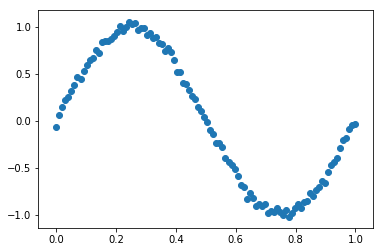

In [7]:
def generateDataset(N, f, sigma):
    mu = 0
    s = np.array(np.random.normal(mu, sigma, N))
    x = np.array(np.linspace(0.0, 1.0, N))
    vf = np.vectorize(f)
    t = np.add(vf(x), s)
    return (x, t)

sigma = 0.03
def f(x): return math.sin(2 * math.pi * x)
N = 100

x, t = generateDataset(N, f, sigma)
plt.scatter(x, t)
plt.show()

### part 2.2

We now want to learn the function y by using x and t using a least squares estimator:

In [8]:
def OptimizeLS(x, t, M):
    phi = np.vstack([np.power(x_i, m) for m in range(M)] for x_i in x)
    prod = np.dot(phi.T, phi)
    i = np.linalg.inv(prod)
    phi_mults = np.dot(i, phi.T)
    w = np.dot(phi_mults, t)
    return w

and we shall test it using the sin function from earlier:

In [ ]:
sigma = 0.03
def f(x): return math.sin(2 * math.pi * x)
N = 10

x, t = generateDataset(N, f, sigma)
plt.figure(figsize=(8, 10))
plt.subplot(5 ,1, 1)
plt.scatter(x, t)

M = [1, 3, 5, 10]
j = 2
for m in M:
    w = OptimizeLS(x, t, m)
    res = np.zeros(len(t))
    for i in range(len(w)):
        res = res + np.dot(w[i], np.power(x, i))
    subp = plt.subplot(5, 1, j)    
    j += 1
    subp.set_title('M = {}'.format(m))
    subp.scatter(x, res)
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.8)
plt.show()

### Part 2.3

Now, instead of least squares we would like to estimate y using polynomial curve fitting:

In [9]:
def optimizePLS(x, t, M, l):
    phi = np.vstack([np.power(x_i, m) for m in range(M)] for x_i in x)
    prod = np.dot(phi.T, phi)
    l_i = np.dot(l, np.identity(prod.shape[0]))
    fixed = np.add(prod, l_i)
    i = np.linalg.inv(fixed)
    phi_mults = np.dot(i, phi.T)
    w = np.dot(phi_mults, t)
    return w

first we will test our function with a random value of lambda:

In [ ]:
sigma = 0.03
def f(x): return math.sin(2 * math.pi * x)
N = 10

x, t = generateDataset(N, f, sigma)
M = 5
l = 0.05
w = optimizePLS(x, t, M, l)

plt.figure(figsize=(8, 10))
plt.subplot(2 ,1, 1)
plt.scatter(x, t)

res = np.zeros(len(t))
for i in range(len(w)):
    res = res + np.dot(w[i], np.power(x, i))
subp = plt.subplot(2, 1, 2)
subp.scatter(x, res)
plt.show()

As we can see, adding the lambda didn't result in the best outcome- 
We want to optimize the lambda value, to do so we will firstly need to construct a training set, a dataset and a validation set in order to optimize it. 
to do so we will extend the function we created earlier:

In [10]:
def generateDataset3(N, f, sigma):
    mu = 0
    s = np.array(np.random.normal(mu, sigma, N))
    
    x_1 = np.array(np.linspace(0.0, 1.0, N))
    x_2 = np.copy(x_1)
    x_3 = np.copy(x_1)
    np.random.shuffle(x_2)
    np.random.shuffle(x_3)
    
    vf = np.vectorize(f)
    
    t_1 = np.add(vf(x_1), s)
    t_2 = np.add(vf(x_2), s)
    t_3 = np.add(vf(x_3), s)
    
    return [(x_1, t_1), (x_2, t_2), (x_3, t_3)]

and testing this function:

In [ ]:
sigma = 0.03
def f(x): return math.sin(2 * math.pi * x)
N = 100

res = generateDataset3(N, f, sigma)
x_1, t_1 = res[0]
x_2, t_2 = res[1]
x_3, t_3 = res[2]
plt.scatter(x_1, t_1)
plt.scatter(x_2, t_2)
plt.scatter(x_3, t_3)
plt.show()

We first need to estimate the error of a model from the real thing, so we define the normalized error:

In [11]:
def N_E(x, t, w):
    err = 0.0
    for i in range(len(t)):
        poly = 0.0
        for m in range(len(w)):
            poly += (w[m] * (x[i] ** m))
        err += (t[i] - poly) ** 2
    err = err ** 0.5
    err = (1 / float(len(t))) * err
    return err

and for example, for the previously generates results we get:

In [ ]:
sigma = 0.03
def f(x): return math.sin(2 * math.pi * x)
N = 100

x, t = generateDataset(N, f, sigma)
M = 5
l = 0.05
w = optimizePLS(x, t, M, l)

print(N_E(x, t, w))

We wanna show how different lambda values will give different result - the following graph plots will show the normalized error on different lambda value for all x types:

In [ ]:
sigma = 0.03
def f(x): return math.sin(2 * math.pi * x)
N = 10

res = generateDataset3(N, f, sigma)
x_test, t_test = res[0]
x_validate, t_validate = res[1]
x_train, t_train = res[2]

def run_lambdas(x_train, t_train, x_test, t_test, x_validate, t_validate):
    j = 0
    normalized_test = np.zeros(20)
    normalized_train = np.zeros(20)
    normalized_validate = np.zeros(20)
    for i in range(-40, -20):
        l = np.exp(i)
        w_test = optimizePLS(x_train, t_train, M, l)
        normalized_test[j] = N_E(x_test, t_test, w_test)
        normalized_validate[j] = N_E(x_validate, t_validate, w_test)
        normalized_train[j] = N_E(x_train, t_train, w_test)
        j += 1
    return [normalized_test, normalized_train, normalized_validate]

def run(N, sigma, f):
    res = generateDataset3(N, f, sigma)
    x_test, t_test = res[0]
    x_validate, t_validate = res[1]
    x_train, t_train = res[2]
    
    return run_lambdas(x_train, t_train, x_test, t_test, x_validate, t_validate)

sigma = 0.03
def f(x): return math.sin(2 * math.pi * x)
N = 10

res = run(N, sigma, f)
n_tst5, n_trn5, n_vld5 = res[0], res[1], res[2]

N = 100
res = run(N, sigma, f)
n_tst10, n_trn10, n_vld10 = res[0], res[1], res[2]

plt.figure(num = 2, figsize=(10, 10))

a_tst = plt.subplot(2 ,3, 1)
a_tst.set_title('N = 10, testing set', y=1.08)
a_tst.plot(n_tst5)
a_v = plt.subplot(2 ,3, 2)
a_v.set_title('N = 10,validtion set', y=1.08)
a_v.plot(n_vld5)
a_t = plt.subplot(2 ,3, 3)
a_t.set_title('N = 10,training set', y=1.08)
a_t.plot(n_trn5)

a_tst_b = plt.subplot(2 ,3, 4)
a_tst_b.set_title('N = 100, testing set', y=1.08)
a_tst_b.plot(n_tst10)
a_v_b = plt.subplot(2 ,3, 5)
a_v_b.set_title('N = 100,validtion set', y=1.08)
a_v_b.plot(n_vld10)
a_t_b = plt.subplot(2 ,3, 6)
a_t_b.set_title('N = 100,training set', y=1.08)
a_t_b.plot(n_trn10)

plt.show()

Now we will create w based on an optimized lambda:

In [ ]:
def optimizePLSLambda(xt, tt, xv, tv, M):
    w_max = np.zeros(M)
    avg_err = 1.0
    for i in range(-40, -20):
        l = np.exp(i)
        w_curr = optimizePLS(xt, tt, M, l)
        curr_err = N_E(xv, tv, w_curr)
        if(curr_err < avg_err):
            avg_err = curr_err
            w_max = np.copy(w_curr)
    return w_max

and testing it on the same example from earlier:

In [ ]:
sigma = 0.03
def f(x): return math.sin(2 * math.pi * x)
N = 10

res = generateDataset3(N, f, sigma)
x_test, t_test = res[0]
x_validate, t_validate = res[1]
x_train, t_train = res[2]

plt.figure(num = 3, figsize=(8, 10))
origin = plt.subplot(2 ,1, 1)
origin.scatter(x_test, t_test)

M = 5
w_res = optimizePLSLambda(x_train, t_train, x_validate, t_validate, M)
res = np.zeros(len(t_test))
for i in range(len(w_res)):
    res = res + np.dot(w_res[i], np.power(x_test, i))
subp = plt.subplot(2, 1, 2)
subp.scatter(x_test, res)
plt.show()


### part 2.4

In [36]:
def bayesianEstimator(x, t, M, alpha, sigma2):
    N = len(x)
    
    #builds phi for given vector xx
    def phi(xx):
        return np.array([(xx ** i) for i in range(M + 1)])
    
    #calculate S
    alpha_i = alpha * np.eye(M + 1)
    S = np.zeros((M + 1, M + 1))
    for i in range(N):
        phi_xi = phi(x[i])
        S += np.outer(phi_xi, phi_xi.T)
    S = np.linalg.inv(alpha_i + (S / sigma2))
    
    #calculate m(x)
    def m(xx):
        phi_t = phi(xx).T
        xt_sum = np.zeros(M + 1)
        for i in range(N):
            xt_sum += phi(x[i]) * t[i]
        return (1 / sigma2) * np.dot(np.dot(phi_t, S), xt_sum)
    
    #calculate s2(xx)
    def var(xx):
        phi_x = phi(xx)
        return sigma2 + np.dot(phi_x.T, np.dot(S, phi_x))
    
    mean = lambda x_t: m(x_t)
    variance = lambda x_t: var(x_t)
    
    return (mean, variance)

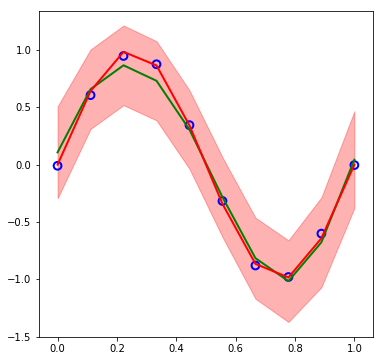

In [52]:
alpha = 0.005
sigma2 = 1/11.1
M = 9
def f(x): return math.sin(2 * math.pi * x)
vf = np.vectorize(f)
N = 10

res = generateDataset(N, f, sigma)
x_t, t_t = res

m, var = bayesianEstimator(x_test, t_test, M, alpha, sigma2)

plt.figure(num = 10, figsize=(6, 6))
upperBound = np.vectorize(lambda x: m(x) + np.sqrt(var(x)))
lowerBound = np.vectorize(lambda x: m(x) - np.sqrt(var(x)))
plt_graph = plt.subplot(111)
plt_graph.fill_between(x_t, upperBound(x_t), lowerBound(x_t), alpha=0.3, color='r')
plt_graph.scatter(x_t, t_t, edgecolor='b', facecolor='none', marker='o', s=60, lw=2)
plt_graph.plot(x_t, m(x_t), lw=2, color='g')
plt_graph.plot(x_t, vf(x_t), lw=2, color='r')

plt.show()